# Kaggle Competition | Titanic: Machine Learning from Disaster 

<br>

![Titanic image](https://i.pinimg.com/736x/22/c0/a3/22c0a33fb77d4c54531580c0c3d232c2--titanic-history-history-books.jpg 'Titanic')

> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

See the competition [homepage](https://www.kaggle.com/c/titanic).

## Structure

This notebook summarizes my first machine learning project on Kaggle. The main highlights are:

* __Data cleasing__ and __Feature Engineering__;
* __Data Visualization__;
* __Model Selection__ and __Hyperparameter Tuning__;
* __Submission__.

## Main Resources

* [Numpy](http://www.numpy.org/) - Array manipulation;
* [Pandas](https://pandas.pydata.org/) - Data importing and cleasing;
* [Matplotlib](https://matplotlib.org/) - Data Visualization;
* [Scikit-learn](http://scikit-learn.org/) - Machine Learning.

#### Import Packages 

In [1]:
# Packages for data handling 
import pandas as pd
import numpy as np
import re

# Packages for modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc_score

# Packages for visuals
import matplotlib.pyplot as plt

# Allows charts to appear in the notebook
%matplotlib inline

** Explore Training Data **

Let's import our training set using pandas and show our first five training examples:

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


__ What do we have here? __

* __PassengerId -__  Passenger's number
* __Survived -__ Survival state (1 = Survived; 0 = Died)
* __Pclass -__ Passenger's class (1 = 1st; 2 = 2nd; 3 = 3rd)
* __Name -__ Passenger's name
* __Sex -__ Passenger's sex (male; female)
* __Age -__ Passenger's age (fractional if less than one)
* __SibSp -__ Number of siblings/spouses aboard
* __Parch -__ Number of parents/children aboard
* __Ticket -__ Ticket's description
* __Fare -__ Passenger's fare
* __Cabin -__ Cabin's description
* __Embarked -__ Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

We can see that each training example is composed of 12 columns. Let's see how many examples do we have:

In [3]:
df_train.shape

(891, 12)

So our training set is composed of 891 examples with 12 columns each.

** Data Cleaning and Feature Engineering **

Now let's see how our data is composed.

In [4]:
df_train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

The feature 'Cabin' has several missing values, so we'll simply discard it. But to keep the features 'Embarked' and 'Age' we will have to deal with this later.

Before moving on, it's always good idea to look at the features we have and try to understand their influence. Data visualization can help!

Let's start with the __Passenger Class__.

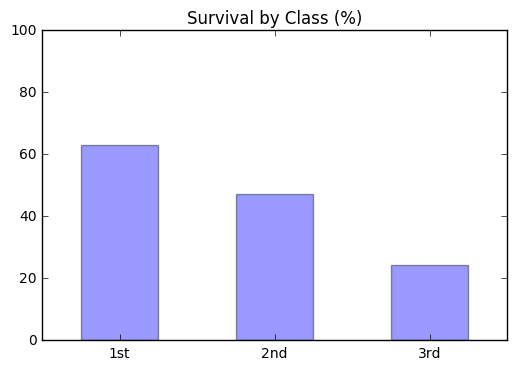

In [5]:
# Calculate how many people boarded per class
raw_counts = df_train.Pclass.value_counts()

# Calculate how many people survived per class
survived_counts = df_train.Pclass[df_train.Survived == 1].value_counts()

# Calculate the probability of survival per class
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4)
ax.set_ylim(0, 100); ax.set_xticklabels(['1st', '2nd', '3rd'], rotation=0);
plt.title("Survival by Class (%)");

So, the higher class passengers were more likely to survive! We saw it coming!
And we can further analyze these odds quantitatively:

In [6]:
# Survival by Pclass
print (df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


What about __Sex__?

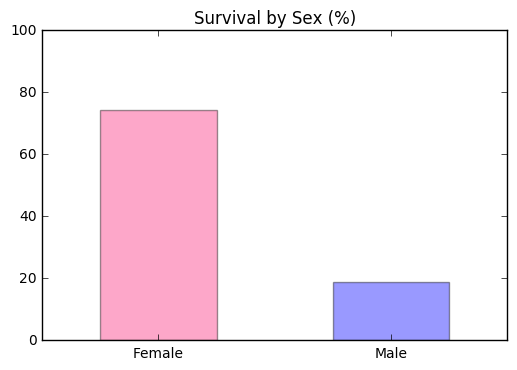

In [7]:
# Calculate how many people boarded per sex
raw_counts = df_train.Sex.value_counts()

# Calculate how many people survived per sex
survived_counts = df_train.Sex[df_train.Survived == 1].value_counts()

# Calculate the probability of survival per sex
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4, color = ['#FA2379', 'blue'])
ax.set_ylim(0, 100); ax.set_xticklabels(['Female', 'Male'], rotation=0);
plt.title("Survival by Sex (%)");

In [8]:
# Survival by Sex
print (df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


Women were much more likely to survive! This also sounds natural.

Now, what kind of information can we extract from the passenger's __Name__? If we look carefully, we realize that it is possible to extract the __Title__ of each person. This is an indicator of the social status of each passenger and therefore may be important!

In [9]:
# Using the re module to look for an expression followed by '.'
def get_title(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title:
        return title.group(1)
    return ''

# Adding Title feature to the training set
df_train['Title'] = df_train['Name'].apply(get_title)

Let's see what we get:

In [10]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Seems good! Now we have another column with the title of each passenger! But how many different titles were found? Let's see.

In [11]:
df_train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Don           1
Lady          1
Mme           1
Countess      1
Sir           1
Ms            1
Capt          1
Name: Title, dtype: int64

There are 4 main titles and several others that include only 1 or 2 passengers. Let's group these titles into a fifth one, which we'll call 'Other'.

In [12]:
df_train['Title'] = df_train['Title'].replace(['Capt', 'Col',
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Other')
df_train['Title'] = df_train['Title'].replace(['Mlle', 'Ms', 'Lady', 'Countess'], 'Miss')
df_train['Title'] = df_train['Title'].replace('Mme', 'Mrs')

And now let's look at the influence of the title on the probability of survival.

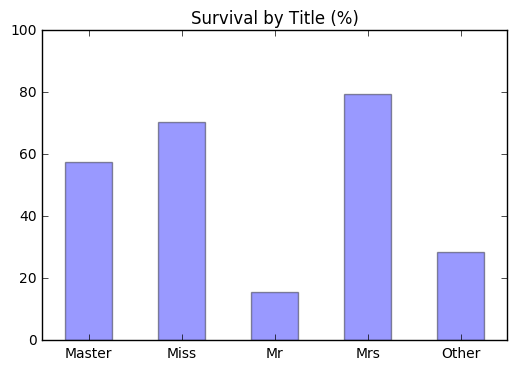

In [13]:
# Calculate how many people boarded per class
raw_counts = df_train.Title.value_counts()

# Calculate how many people survived per class
survived_counts = df_train.Title[df_train.Survived == 1].value_counts()

# Calculate the probability of survival per class
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4)
ax.set_ylim(0, 100); ax.set_xticklabels(['Master', 'Miss', 'Mr', 'Mrs', 'Other'], rotation=0);
plt.title("Survival by Title (%)");

In [14]:
# Title
print (df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.705882
2      Mr  0.156673
3     Mrs  0.793651
4   Other  0.285714


The titles really seem to have great influence. That's nice!

Now let's look at the __Age__. As we have seen earlier, there are several missing age values. We will fill these values, using the average age of the social title to which the passenger belongs.

In [15]:
# Dealing with Missing Values

# Identify the passengers who share each title and calculate their average age
Master_index = df_train['Age'][df_train['Title'] == 'Master'].index.tolist()
Master_mean = df_train['Age'][df_train['Title'] == 'Master'].mean()
Miss_index = df_train['Age'][df_train['Title'] == 'Miss'].index.tolist()
Miss_mean = df_train['Age'][df_train['Title'] == 'Miss'].mean()
Mr_index = df_train['Age'][df_train['Title'] == 'Mr'].index.tolist()
Mr_mean = df_train['Age'][df_train['Title'] == 'Mr'].mean()
Mrs_index = df_train['Age'][df_train['Title'] == 'Mrs'].index.tolist()
Mrs_mean = df_train['Age'][df_train['Title'] == 'Mrs'].mean()
Other_index = df_train['Age'][df_train['Title'] == 'Other'].index.tolist()
Other_mean = df_train['Age'][df_train['Title'] == 'Other'].mean()

# Update training set
df_train.iloc[Master_index, 5] = df_train.iloc[Master_index, 5].fillna(Master_mean);
df_train.iloc[Miss_index, 5] = df_train.iloc[Miss_index, 5].fillna(Miss_mean);
df_train.iloc[Mr_index, 5] = df_train.iloc[Mr_index, 5].fillna(Mr_mean);
df_train.iloc[Mrs_index, 5] = df_train.iloc[Mrs_index, 5].fillna(Mrs_mean);
df_train.iloc[Other_index, 5] = df_train.iloc[Other_index, 5].fillna(Other_mean);

Now let's confirm that the missing age values have been filled out!

In [16]:
df_train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
Title          891
dtype: int64

Done. Now we are ready to analyze the influence of age on the probability of survival:

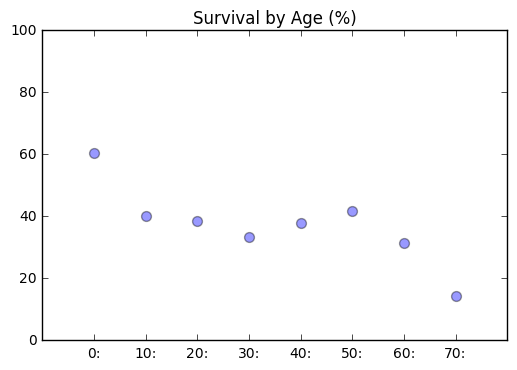

In [17]:
# As the age is a continuous variable, let's group it into groups
# [0, 10]; [10, 20]; [20, 30]; [30, 40]; [40, 50]; [50, 60]; [60, 70]; [70, max]
bins = list(i for i in range (0,int(df_train.Age.max())+ 10,10))

# Calculate how many people boarded per age
raw_counts = np.histogram(df_train.Age, bins = bins)[0]

# Calculate how many people survived per age
survived_counts = np.histogram(df_train.Age[df_train.Survived == 1], bins = bins)[0]

# Calculate the probability of survival per age
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.scatter(bins[0:-1], probs, s= 50, alpha=0.4)
ax.set_ylim(0, 100);
ax.set_xticklabels(['','0:','10:','20:','30:','40:','50:','60:','70:',''], rotation=0);
plt.title("Survival by Age (%)");

So, it is clear that children aged 0 to 10 years (0: on the figure) had much greater chances of surviving. On the other hand, few people over 70 did not die!

Along with what we had seen regarding sex, this seems to prove the old code of conduct __"Women and children first"__!

Moving on, let's look at the __SibSp__ and __Parch__ columns, which represent the  number of siblings/spouses and the number of parents/children aboard, respectively. Is the information in these columns so different? Intuitively, having a sibling or a parent aboard may have very similar effects. So let's use these two columns together, creating a new feature called __FamilySize__.

In [18]:
# Using SibSp and Parch to build feature FamilySize
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1


Done! Now let's see if this new feature has influence:

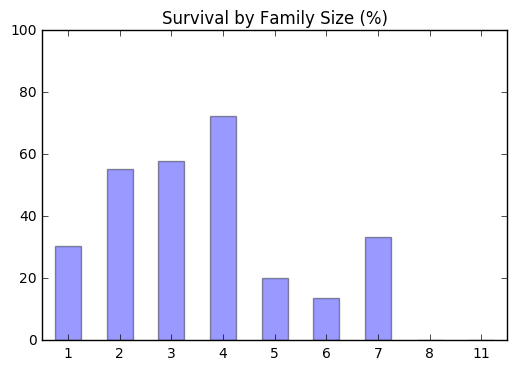

In [19]:
# Calculate how many people boarded per FamilySize
raw_counts = df_train.FamilySize.value_counts()

# Calculate how many people survived per FamilySize
survived_counts = df_train.FamilySize[df_train.Survived == 1].value_counts()

# Calculate the probability of survival per FamilySize
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4)
ax.set_ylim(0, 100); 
plt.xticks(rotation=0);
plt.title("Survival by Family Size (%)");

In [20]:
print (df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


So it seems that those who had 1, 2 or 3 family members on board were more likely to survive than those who were alone. However, for those who had many relatives to worry about those odds dropped dramatically!

Now, let's use the age to signal whether a person is a __child__ or a __elderly__.

In [21]:
# Building IsChild feature
df_train['IsChild'] = 0
df_train.loc[df_train['Age'] < 13, 'IsChild'] = 1

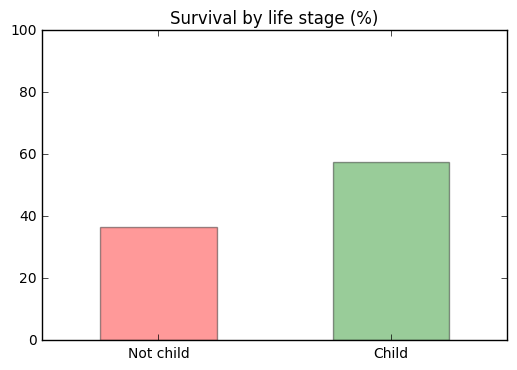

In [22]:
# Calculate how many child boarded 
raw_counts = df_train.IsChild.value_counts()

# Calculate how many child survived 
survived_counts = df_train.IsChild[df_train.Survived == 1].value_counts()

# Calculate the probability of a child surviving
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4, color = ['red', 'green'])
ax.set_ylim(0, 100); ax.set_xticklabels(['Not child', 'Child'], rotation=0);
plt.title("Survival by life stage (%)");

In [23]:
print (df_train[['IsChild', 'Survived']].groupby(['IsChild'], as_index=False).mean())

   IsChild  Survived
0        0  0.366748
1        1  0.575342


In [24]:
# Building IsElderly feature
df_train['IsElderly'] = 0
df_train.loc[df_train['Age'] > 65, 'IsElderly'] = 1

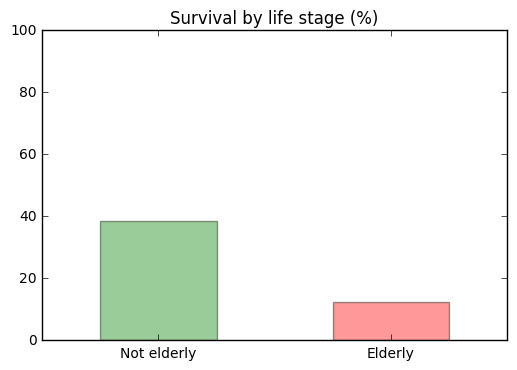

In [25]:
# Calculate how many child boarded 
raw_counts = df_train.IsElderly.value_counts()

# Calculate how many child survived 
survived_counts = df_train.IsElderly[df_train.Survived == 1].value_counts()

# Calculate the probability of a child surviving
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4, color = ['green', 'red'])
ax.set_ylim(0, 100); ax.set_xticklabels(['Not elderly', 'Elderly'], rotation=0);
plt.title("Survival by life stage (%)");

In [26]:
print (df_train[['IsElderly', 'Survived']].groupby(['IsElderly'], as_index=False).mean())

   IsElderly  Survived
0          0  0.386183
1          1  0.125000


As expected, these features seem to have a big impact. 

Now let's look at the __Fare__.

To visualize the data, we will use a strategy similar to that used for age. In particular, we will group the amount paid into five groups.

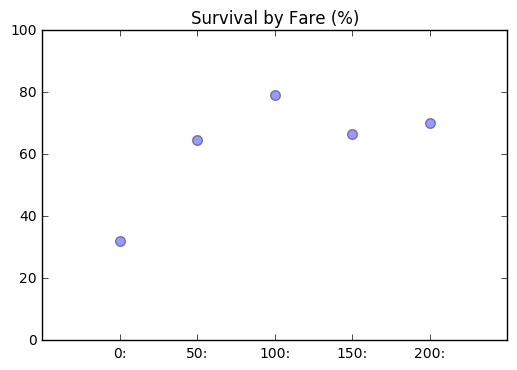

In [27]:
# Grouping the fare into 5 groups
# [0, 50]; [50, 100]; [100, 150]; [150, 200]; [200, max]; 
bins = [0, 50, 100, 150, 200, df_train.Fare.max()]

# Calculate how many people boarded per group fare
raw_counts = np.histogram(df_train.Fare, bins = bins)[0]

# Calculate how many people survived per group fare
survived_counts = np.histogram(df_train.Fare[df_train.Survived == 1], bins = bins)[0]

# Calculate the probability of survival per age
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.scatter(bins[0:-1], probs, s= 50, alpha=0.4)
ax.set_ylim(0, 100);
ax.set_xticklabels(['','0:','50:','100:','150:','200:',''], rotation=0);
plt.title("Survival by Fare (%)");

We can clearly see that people with a cheaper ticket ([0, 50]) had much less chance of surviving!

Finally, let's look at the port of embarkation. As we have already seen, in this case there are also missing values, so we will start by associating these values with the most common embarkation place ('S').

In [28]:
# Dealing with Missing Values
df_train['Embarked'].fillna(df_train['Embarked'].value_counts().index[0], inplace = True);

And now we can analyse what this feature tells us:

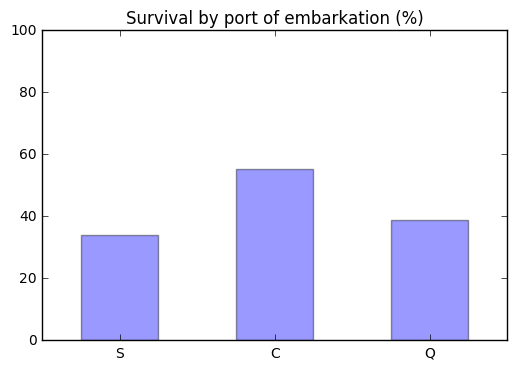

In [29]:
# Calculate how many people boarded by port
raw_counts = df_train.Embarked.value_counts()

# Calculate how many people survived by port
survived_counts = df_train.Embarked[df_train.Survived == 1].value_counts()

# Calculate the probability of surviving by port
probs = 100 * survived_counts/raw_counts

# Create new figure and plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
probs.plot(kind="bar", alpha=0.4)
ax.set_ylim(0, 100); ax.set_xticklabels(['S', 'C', 'Q'], rotation=0);
plt.title("Survival by port of embarkation (%)");

In [30]:
print (df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


So, we found something interesting! The people who boarded in Cherbourg were luckier!

__ Feature Selection __

Now is the time to select our features. First let's see what is the current state of our dataset.

In [31]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsChild,IsElderly
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,0,0


Let's drop some features with too many missing values or redundant information.

In [32]:
# Droping some columns and updating dataset
df_train.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace = True);
df_train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsChild,IsElderly
0,1,0,3,male,22.0,7.2500,S,Mr,2,0,0
1,2,1,1,female,38.0,71.2833,C,Mrs,2,0,0
2,3,1,3,female,26.0,7.9250,S,Miss,1,0,0
3,4,1,1,female,35.0,53.1000,S,Mrs,2,0,0
4,5,0,3,male,35.0,8.0500,S,Mr,1,0,0


Looks better! Now, we only have to deal with categorical (non-numerical) variables. Here we will use  labelencoder(). Another alternative would be dummy variables.

In [33]:
# Dealing with Categorical Variables
encoder = LabelEncoder()
df_train[['Sex', 'Title', 'Embarked']] = df_train[['Sex', 'Title', 'Embarked']].apply(encoder.fit_transform)
#df_train = pd.get_dummies(df_train, columns = ['Sex', 'Title', 'Embarked'], drop_first = True)
df_train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsChild,IsElderly
0,1,0,3,1,22.0,7.2500,2,2,2,0,0
1,2,1,1,0,38.0,71.2833,0,3,2,0,0
2,3,1,3,0,26.0,7.9250,2,1,1,0,0
3,4,1,1,0,35.0,53.1000,2,3,2,0,0
4,5,0,3,1,35.0,8.0500,2,2,1,0,0


** Extract Inputs **

After cleaning and preparing our dataset, we can set the feature matrix __X__ and the labels __y__.

In [34]:
# Specify inputs for the model
y = df_train['Survived']
X = df_train[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 
              'IsChild', 'IsElderly']].as_matrix()

In machine learning, it is good practice to normalize the features X so that they have zero mean and unit standard deviation.

In [35]:
# Feature standardization
scaler = StandardScaler().fit(X);
X = scaler.transform(X);

** Model Selection **

In this project, we will be using __S__upport __V__ector __M__achines due to its computational efficiency and reduced number of hyperparameters.

__Hyperparameter Tuning __

To do the hyperparameter tunning we will use _k_-fold cross-validation, with k = 5. __Gridsearch__ allows us to do this much more efficiently and has the advantage of dividing folds automatically.

We will use only one Gaussian kernel, testing different values for __C__ and __gamma__.

In [36]:
# Set the parameters by cross-validation
param_grid = [{'C': [1, 3, 5, 10, 30, 100, 300], 'gamma': [1e-5, 1e-4, 1e-3, 1e-2], 'kernel': ['rbf']}]

scores = ['accuracy']

for score in scores:
    print('Tuning hyper-parameters for %s!\n' % score)
    
    grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='%s' % score);
    grid.fit(X, y);

    print('All scores: \n')
    
    means_test = grid.cv_results_['mean_test_score'];
    stds_test = grid.cv_results_['std_test_score'];
    means_train = grid.cv_results_['mean_train_score'];
    stds_train = grid.cv_results_['std_train_score'];
    params = grid.cv_results_['params'];
    for m_test, st_test, m_train, st_train, param in zip(means_test, stds_test, means_train, stds_train, params):
        print("Test: %0.3f (+/-%0.03f) Train: %0.3f (+/-%0.03f) for Parameters: %r" 
              %(m_test, st_test, m_train, st_train, param))
        
    print('\nBest test score: \n')
    print('%0.3f' %grid.best_score_, grid.best_params_)

Tuning hyper-parameters for accuracy!

All scores: 

Test: 0.616 (+/-0.002) Train: 0.616 (+/-0.000) for Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 1e-05}
Test: 0.616 (+/-0.002) Train: 0.616 (+/-0.000) for Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
Test: 0.790 (+/-0.016) Train: 0.801 (+/-0.004) for Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
Test: 0.795 (+/-0.020) Train: 0.803 (+/-0.008) for Parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 0.01}
Test: 0.616 (+/-0.002) Train: 0.616 (+/-0.000) for Parameters: {'C': 3, 'kernel': 'rbf', 'gamma': 1e-05}
Test: 0.617 (+/-0.002) Train: 0.618 (+/-0.002) for Parameters: {'C': 3, 'kernel': 'rbf', 'gamma': 0.0001}
Test: 0.788 (+/-0.020) Train: 0.789 (+/-0.004) for Parameters: {'C': 3, 'kernel': 'rbf', 'gamma': 0.001}
Test: 0.819 (+/-0.021) Train: 0.824 (+/-0.007) for Parameters: {'C': 3, 'kernel': 'rbf', 'gamma': 0.01}
Test: 0.616 (+/-0.002) Train: 0.616 (+/-0.000) for Parameters: {'C': 5, 'kernel': 'rbf', 'gamma': 1e-05}
Te

/home/americo/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/americo/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


** Results on Training set **

Gridsearch tests all possible combinations of parameters and automatically saves the best model. So we can use it to make predictions.

In [37]:
# Accuracy on training set
y_pred = grid.predict(X)
acc_score (y,y_pred)

0.83950617283950613

So our best model gets __84%__ of accuracy on the __training__ set.

Now let's see how it behaves on the test set!

** Import Test Data **

We will start by importing the test set:

In [38]:
# Read test data
df_test = pd.read_csv('test.csv')
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


And by seeing how many test examples do we have:

In [39]:
df_test.shape

(418, 11)

** Feature Engineering **

Now let's build the features Title and Family Size as we did for the training set.

In [40]:
# Using Name to build feature Title
df_test['Title'] = df_test['Name'].apply(get_title)

df_test['Title'] = df_test['Title'].replace(['Capt', 'Col',
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Other')
df_test['Title'] = df_test['Title'].replace(['Mlle', 'Ms', 'Lady', 'Countess', 'Dona'], 'Miss')
df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')

In [41]:
# Using SibSp and Parch to build feature FamilySize
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

Before moving on, we have to fill the missing values on the Fare and Age columns:

In [42]:
df_test.count()

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
Title          418
FamilySize     418
dtype: int64

So let's do it:

In [43]:
# Dealing with Missing Values

# Fare Feature
df_test['Fare'].fillna(df_train['Fare'].mean(), inplace = True);

# Age Feature
Master_index = df_test['Age'][df_test['Title'] == 'Master'].index.tolist()
Miss_index = df_test['Age'][df_test['Title'] == 'Miss'].index.tolist()
Mr_index = df_test['Age'][df_test['Title'] == 'Mr'].index.tolist()
Mrs_index = df_test['Age'][df_test['Title'] == 'Mrs'].index.tolist()
Other_index = df_test['Age'][df_test['Title'] == 'Other'].index.tolist()

df_test.iloc[Master_index, 4] = df_test.iloc[Master_index, 4].fillna(Master_mean);
df_test.iloc[Miss_index, 4] = df_test.iloc[Miss_index, 4].fillna(Miss_mean);
df_test.iloc[Mr_index, 4] = df_test.iloc[Mr_index, 4].fillna(Mr_mean);
df_test.iloc[Mrs_index, 4] = df_test.iloc[Mrs_index, 4].fillna(Mrs_mean);
df_test.iloc[Other_index, 4] = df_test.iloc[Other_index, 4].fillna(Other_mean);

And check it:

In [44]:
df_test.count()

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            418
SibSp          418
Parch          418
Ticket         418
Fare           418
Cabin           91
Embarked       418
Title          418
FamilySize     418
dtype: int64

Having filling the gaps, we can use the Age and Fair to build the other features:

In [45]:
# Using Age to build to more features
df_test['IsChild'] = 0
df_test.loc[df_test['Age'] < 13, 'IsChild'] = 1

df_test['IsElderly'] = 0
df_test.loc[df_test['Age'] > 65, 'IsElderly'] = 1

And we end up with:

In [46]:
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsChild,IsElderly
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,2,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,3,0,0


Now we just have to drop the columns that we don't need:

In [47]:
# Feature Selection
df_test.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace = True);
df_test.head(5)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsChild,IsElderly
0,892,3,male,34.5,7.8292,Q,Mr,1,0,0
1,893,3,female,47.0,7.0000,S,Mrs,2,0,0
2,894,2,male,62.0,9.6875,Q,Mr,1,0,0
3,895,3,male,27.0,8.6625,S,Mr,1,0,0
4,896,3,female,22.0,12.2875,S,Mrs,3,0,0


And, once more, to deal with the categorical variables:

In [48]:
# Dealing with Categorical Variables
df_test[['Sex','Embarked', 'Title']] = df_test[['Sex','Embarked', 'Title']].apply(encoder.fit_transform)
#df_test = pd.get_dummies(df_test, columns = ['Sex', 'Title', 'Embarked'], drop_first = True)
df_test.head(2)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsChild,IsElderly
0,892,3,1,34.5,7.8292,1,2,1,0,0
1,893,3,0,47.0,7.0000,2,3,2,0,0


Great! Almost there!

** Predict **

Let's build __X_test__ and normalize it with the training values. Then we can creat __y_test__ using the predict() method.

In [49]:
# Specify inputs for the model
X_test = df_test.drop(['PassengerId'], axis = 1).as_matrix()
X_test = scaler.transform(X_test);

# Predict
y_pred = grid.predict(X_test)

As a sanity check, let's just confirm if __y_pred__ has the expected shape (418x1):

In [50]:
y_pred.shape

(418,)

** Export csv file **

Perfect!
Now we can build a DataFrame with our submission and use to_csv() method to export the submition file!

In [51]:
#Building dataframe
df_sub = pd.DataFrame()
df_sub['PassengerId'] = df_test['PassengerId'] 
df_sub['Survived'] = y_pred

In [52]:
#Exporting
df_sub.to_csv('/home/americo/Desktop/submission.csv', index=False)

Our submission on Kaggle reached __0.79425__ on the __test__ set.